In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

print('Libraries Loaded')

Libraries Loaded


In [2]:
## Utilities 

def read_file(path):
    df= pd.read_excel(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being copied from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

In [3]:
## Loading the file 

src = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Data'
filename = r'Pave_data_cleaned.xlsx'

dest = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Solutions'

df = read_file(os.path.join(src,filename))

(10896, 7)
   Year  Month  Day  Hour  Temp  Solar  Pavement
0  2009     11    1     1   8.4    0.0  9.333333
1  2009     11    1     2   8.3    0.0  8.933333
2  2009     11    1     3   7.9    0.0  8.700000
3  2009     11    1     4   7.6    0.0  8.533333
4  2009     11    1     5   6.9    0.0  8.533333


In [4]:
## Training the training and testing data

x_train,x_test,y_train,y_test,scaler = splitter(df[['Temp','Pavement']],['Pavement'],24,6,0.8)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(8716, 2) (2180, 2)
The shape of x_train is (8686, 24, 2) and x_test is (2150, 24, 2)
The shape of y_train is (8686, 6) and y_test is (2150, 6)


## LSTM Model

In [5]:
## Creating the prelimaries 

filepath_simple = 'simple_lstm.hdf5'
filepath_attention = 'attention_lstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [6]:
## Simple LSTM
K.clear_session()
simple_lstm = keras.Sequential()
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Flatten())
simple_lstm.add(keras.layers.Dense(512, activation='relu'))
simple_lstm.add(keras.layers.Dense(128, activation='relu'))
simple_lstm.add(keras.layers.Dense(64, activation='relu'))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.Dense(32))
simple_lstm.add(keras.layers.Dense(6))

simple_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

In [ ]:
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = simple_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

simple_lstm.load_weights(filepath_simple)
preds = simple_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


Directory present
Epoch 1/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0123 - mae: 0.0804 - val_loss: 0.0024 - val_mae: 0.0386
Epoch 2/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0055 - mae: 0.0554 - val_loss: 0.0030 - val_mae: 0.0422
Epoch 3/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0044 - mae: 0.0487 - val_loss: 0.0018 - val_mae: 0.0334
Epoch 4/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0035 - mae: 0.0427 - val_loss: 0.0012 - val_mae: 0.0275
Epoch 5/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0029 - mae: 0.0391 - val_loss: 0.0010 - val_mae: 0.0257
Epoch 6/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0026 - mae: 0.0372 - val_loss: 8.5992e-04 - val_mae: 0.0231
Epoch 7/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0023 - mae: 0.0347 - val_loss: 9.4382e-04 - val_mae: 0.0236
Epoch 8/200
245/245 [=====================

245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 4.7764e-04 - val_mae: 0.0161
Epoch 61/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 4.6118e-04 - val_mae: 0.0160
Epoch 62/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 4.9449e-04 - val_mae: 0.0165
Epoch 63/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 5.5637e-04 - val_mae: 0.0186
Epoch 64/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 5.4299e-04 - val_mae: 0.0178
Epoch 65/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0241 - val_loss: 5.2563e-04 - val_mae: 0.0174
Epoch 66/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 5.4610e-04 - val_mae: 0.0183
Epoch 67/200
245/245 [=========================

245/245 [==============================] - 2s 7ms/step - loss: 8.9575e-04 - mae: 0.0216 - val_loss: 4.2548e-04 - val_mae: 0.0151
Epoch 119/200
245/245 [==============================] - 2s 7ms/step - loss: 9.3316e-04 - mae: 0.0219 - val_loss: 7.4406e-04 - val_mae: 0.0205
Epoch 120/200
245/245 [==============================] - 2s 7ms/step - loss: 9.2704e-04 - mae: 0.0219 - val_loss: 5.5844e-04 - val_mae: 0.0185
Epoch 121/200
245/245 [==============================] - 2s 7ms/step - loss: 9.2129e-04 - mae: 0.0221 - val_loss: 7.4165e-04 - val_mae: 0.0208
Epoch 122/200
245/245 [==============================] - 2s 7ms/step - loss: 8.5709e-04 - mae: 0.0213 - val_loss: 5.4138e-04 - val_mae: 0.0178
Epoch 123/200
245/245 [==============================] - 2s 7ms/step - loss: 8.6919e-04 - mae: 0.0211 - val_loss: 4.7449e-04 - val_mae: 0.0165
Epoch 124/200
245/245 [==============================] - 2s 7ms/step - loss: 8.9850e-04 - mae: 0.0215 - val_loss: 5.5397e-04 - val_mae: 0.0182
Epoch 125/200

In [ ]:
## Attention model

K.clear_session()
atten_lstm = keras.Sequential()
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
# atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Flatten())
atten_lstm.add(keras.layers.Dense(512, activation='relu'))
atten_lstm.add(keras.layers.Dense(128, activation='relu'))
atten_lstm.add(keras.layers.Dense(64, activation='relu'))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.Dense(32))
atten_lstm.add(keras.layers.Dense(6))

atten_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

In [ ]:
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = atten_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_lstm.load_weights(filepath_attention)
preds = atten_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)

wk.save(f'LSTM Result.xls')

## CNN-LSTM

In [ ]:
## Creating the prelimaries 

filepath_simple = 'simple_cnnlstm.hdf5'
filepath_attention = 'attention_cnnlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [ ]:
K.clear_session()
simple_cnnlstm = keras.Sequential()
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.Flatten())
simple_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(32))
simple_cnnlstm.add(keras.layers.Dense(6))

simple_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

In [ ]:
try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

# history = simple_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

# plt.plot(history.history['loss'],'r',label='Training Loss')
# plt.plot(history.history['val_loss'],'b',label='Validation Loss')
# plt.legend()
# plt.show()

simple_cnnlstm.load_weights(filepath_simple)
preds = simple_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [ ]:
## Attention model

K.clear_session()
atten_cnnlstm = keras.Sequential()
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(attention(return_sequences=True))
atten_cnnlstm.add(keras.layers.Flatten())
atten_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(32))
atten_cnnlstm.add(keras.layers.Dense(6))

atten_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

In [ ]:
try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

# history = atten_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

# plt.plot(history.history['loss'],'r',label='Training Loss')
# plt.plot(history.history['val_loss'],'b',label='Validation Loss')
# plt.legend()
# plt.show()

atten_cnnlstm.load_weights(filepath_attention)
preds = atten_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('CNN-LStM Results.xls')

## ConvLSTM Model

In [ ]:
## Creating the prelimaries 

filepath_simple = 'simple_convlstm.hdf5'
filepath_attention = 'attention_convlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [ ]:
x_train_conv =x_train.reshape(x_train.shape[0], 1, 1, x_train.shape[1], x_train.shape[2])
x_test_conv = x_test.reshape(x_test.shape[0], 1, 1, x_test.shape[1], x_test.shape[2])

In [ ]:
K.clear_session()
simple_convlstm = keras.Sequential()
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
simple_convlstm.add(keras.layers.Flatten())
simple_convlstm.add(keras.layers.Dense(512, activation='relu'))
simple_convlstm.add(keras.layers.Dense(128, activation='relu'))
simple_convlstm.add(keras.layers.Dense(64, activation='relu'))
simple_convlstm.add(keras.layers.Dense(32))
simple_convlstm.add(keras.layers.Dense(6))

simple_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

In [ ]:
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = simple_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_convlstm.load_weights(filepath_simple)
preds = simple_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [ ]:
K.clear_session()
atten_convlstm = keras.Sequential()
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
atten_convlstm.add(attention(return_sequences=True))
atten_convlstm.add(keras.layers.Flatten())
atten_convlstm.add(keras.layers.Dense(512, activation='relu'))
atten_convlstm.add(keras.layers.Dense(128, activation='relu'))
atten_convlstm.add(keras.layers.Dense(64, activation='relu'))
atten_convlstm.add(keras.layers.Dense(32))
atten_convlstm.add(keras.layers.Dense(6))

atten_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

In [ ]:
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = atten_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_convlstm.load_weights(filepath_attention)
preds = atten_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('ConvLSTM Results.xls')

## Seq2Seq Model

In [ ]:
## Creating the prelimaries 

filepath_simple = 'simple_seq2seq.hdf5'
filepath_attention = 'attention_seq2seq.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [ ]:
y_train_seq = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [ ]:
K.clear_session()
input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

## Encoder Section##
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=False, return_state=True)(encoder_third)

##Decorder Section##
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first,initial_state=[encoder_fourth,encoder_fourth_s2])
decoder_third = keras.layers.LSTM(128,return_sequences=True)(decoder_second)
decoder_fourth = keras.layers.LSTM(128,return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128,return_sequences=True)(decoder_fourth)
print(decoder_fifth)

##Output Section##
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_fifth)

simple_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=0.001)
simple_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
simple_seq.summary()

In [ ]:
try:
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Seq2Seq')
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('New Directory Created')

history = simple_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_seq.load_weights(filepath_simple)
preds = simple_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [ ]:
 K.clear_session()

input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

## Encoder Section##
encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=True,return_state=True)(encoder_third)

##Decoder Section##
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth_s1)
decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first, initial_state=[encoder_fourth_s1, encoder_fourth_s2])

attention = keras.layers.dot([decoder_second, encoder_fourth], axes=[2, 2])
attention = keras.layers.Activation('softmax')(attention)
context = keras.layers.dot([attention, encoder_fourth], axes=[2, 1])

decoder_third = keras.layers.concatenate([context, decoder_second])

decoder_fourth = keras.layers.LSTM(128, return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(128, return_sequences=True)(decoder_fourth)
decoder_sixth = keras.layers.LSTM(128, return_sequences=True)(decoder_fifth)

##Output Section##
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_sixth)

atten_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=0.0001)
atten_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
atten_seq.summary()

In [ ]:
try:
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Seq2Seq')
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('New Directory Created')

history = atten_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_seq.load_weights(filepath_attention)
preds = atten_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('Seq2Seq Results.xls')

## Wavenet Model

In [8]:
## Creating the prelimaries 

filepath_simple = 'simple_wavenet.hdf5'
filepath_attention = 'attention_wavenet.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [13]:
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = keras.layers.Conv1D(64, 1, padding='same')(x) 
    x_f = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = keras.layers.Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(z)

    x = keras.layers.Add()([x, z])    

    skips.append(z)

out = keras.layers.Activation('relu')(keras.layers.Add()(skips)) 
out = keras.layers.Conv1D(128, 1, padding='same')(out)
out = keras.layers.Activation('relu')(out)
out = keras.layers.Dropout(0.4)(out)
out = keras.layers.Conv1D(1, 1, padding='same')(out)

out = keras.layers.Flatten()(out)
out = keras.layers.Dense(6)(out)

simple_wavenet = keras.Model(inputs, out)

simple_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])


In [14]:
try:
    os.chdir(os.path.join(dest,'Wavenet'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Wavenet')
    os.chdir(os.path.join(dest,'Wavenet'))
    print('New Directory Created')

# history = simple_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

# plt.plot(history.history['loss'],'r',label='Training Loss')
# plt.plot(history.history['val_loss'],'b',label='Validation Loss')
# plt.legend()
# plt.show()

simple_wavenet.load_weights(filepath_simple)
preds = simple_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


Directory present
(2150, 6)
The Mean Squared Error is: 5.5206542048612635


In [10]:
n_filters = 128
filter_width = 2
dilation_rates = [2**i for i in range(7)]

inputs = Input(shape=(x_train.shape[1],x_train.shape[2]))
x=inputs

skips = []
for dilation_rate in dilation_rates:

    x   = Conv1D(64, 1, padding='same')(x) 
    x_f = Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
    x_g = Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

    z = Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

    z = Conv1D(64, 1, padding='same', activation='relu')(z)

    x = Add()([x, z])    

    skips.append(z)

out = Activation('relu')(keras.layers.Add()(skips)) 
out = attention(return_sequences=True)(out)
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(0.4)(out)
out = Conv1D(1, 1, padding='same')(out)
# out = attention(return_sequences=True)(out)
out = Flatten()(out)
out = Dense(6)(out)

atten_wavenet = keras.Model(inputs, out)

atten_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
atten_wavenet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 2)]      0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 24, 64)       192         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 24, 128)      16512       conv1d_30[0][0]                  
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 24, 128)      16512       conv1d_30[0][0]                  
_______________________________________________________________________________________

Directory present
Epoch 1/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0099 - mae: 0.0668 - val_loss: 0.0016 - val_mae: 0.0311
Epoch 2/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0035 - mae: 0.0438 - val_loss: 0.0013 - val_mae: 0.0283
Epoch 3/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0028 - mae: 0.0388 - val_loss: 9.7996e-04 - val_mae: 0.0239
Epoch 4/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0021 - mae: 0.0338 - val_loss: 9.1804e-04 - val_mae: 0.0236
Epoch 5/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0019 - mae: 0.0317 - val_loss: 9.1355e-04 - val_mae: 0.0232
Epoch 6/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 8.9225e-04 - val_mae: 0.0234
Epoch 7/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0017 - mae: 0.0296 - val_loss: 0.0012 - val_mae: 0.0282
Epoch 8/200
245/245 [=============

245/245 [==============================] - 2s 8ms/step - loss: 1.6792e-04 - mae: 0.0098 - val_loss: 5.9163e-04 - val_mae: 0.0183
Epoch 117/200
245/245 [==============================] - 2s 8ms/step - loss: 1.6488e-04 - mae: 0.0097 - val_loss: 6.7407e-04 - val_mae: 0.0200
Epoch 118/200
245/245 [==============================] - 2s 8ms/step - loss: 1.7305e-04 - mae: 0.0099 - val_loss: 6.4008e-04 - val_mae: 0.0192
Epoch 119/200
245/245 [==============================] - 2s 8ms/step - loss: 1.9132e-04 - mae: 0.0105 - val_loss: 5.9929e-04 - val_mae: 0.0184
Epoch 120/200
245/245 [==============================] - 2s 8ms/step - loss: 1.7495e-04 - mae: 0.0100 - val_loss: 5.9747e-04 - val_mae: 0.0188
Epoch 121/200
245/245 [==============================] - 2s 8ms/step - loss: 1.5618e-04 - mae: 0.0094 - val_loss: 6.1097e-04 - val_mae: 0.0185
Epoch 122/200
245/245 [==============================] - 2s 8ms/step - loss: 1.6975e-04 - mae: 0.0098 - val_loss: 6.3204e-04 - val_mae: 0.0184
Epoch 123/200

245/245 [==============================] - 2s 8ms/step - loss: 1.4446e-04 - mae: 0.0090 - val_loss: 7.1011e-04 - val_mae: 0.0197
Epoch 174/200
245/245 [==============================] - 2s 8ms/step - loss: 1.2960e-04 - mae: 0.0085 - val_loss: 6.4048e-04 - val_mae: 0.0192
Epoch 175/200
245/245 [==============================] - 2s 8ms/step - loss: 1.1359e-04 - mae: 0.0080 - val_loss: 6.7580e-04 - val_mae: 0.0195
Epoch 176/200
245/245 [==============================] - 2s 8ms/step - loss: 1.2376e-04 - mae: 0.0084 - val_loss: 7.8303e-04 - val_mae: 0.0217
Epoch 177/200
245/245 [==============================] - 2s 8ms/step - loss: 1.2806e-04 - mae: 0.0085 - val_loss: 7.0585e-04 - val_mae: 0.0200
Epoch 178/200
245/245 [==============================] - 2s 8ms/step - loss: 1.2927e-04 - mae: 0.0085 - val_loss: 6.5420e-04 - val_mae: 0.0191
Epoch 179/200
245/245 [==============================] - 2s 8ms/step - loss: 1.4773e-04 - mae: 0.0091 - val_loss: 7.0540e-04 - val_mae: 0.0204
Epoch 180/200

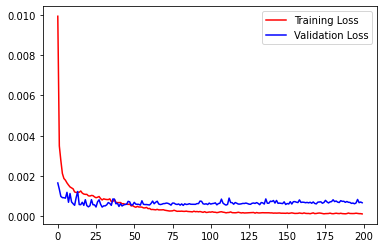

(2150, 6)
The Mean Squared Error is: 6.485297764252889


In [11]:
try:
    os.chdir(os.path.join(dest,'Wavenet'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Wavenet')
    os.chdir(os.path.join(dest,'Wavenet'))
    print('New Directory Created')

history = atten_wavenet.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_wavenet.load_weights(filepath_attention)
preds = atten_wavenet.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('Wavenet Results.xls')

In [15]:
wk.save('Wavenet Results.xls')